<a href="https://colab.research.google.com/github/meeswarna13/Iris_dataset/blob/main/XGBoost_Calories_Burnt_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
calorie = pd.read_csv('/content/calories.csv')
exercise = pd.read_csv('/content/exercise.csv')

In [ ]:
df = pd.merge(calorie, exercise, on='User_ID')
df.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
df.shape

(15000, 9)

In [ ]:
df.isnull().sum()

,0
User_ID,0
Calories,0
Gender,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
df.describe()

,User_ID,Calories,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,89.539533,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453
std,2.872851e+06,62.456978,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230
min,1.000116e+07,1.000000,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000
25%,1.247419e+07,35.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000
50%,1.499728e+07,79.000000,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000
75%,1.744928e+07,138.000000,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000
max,1.999965e+07,314.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000


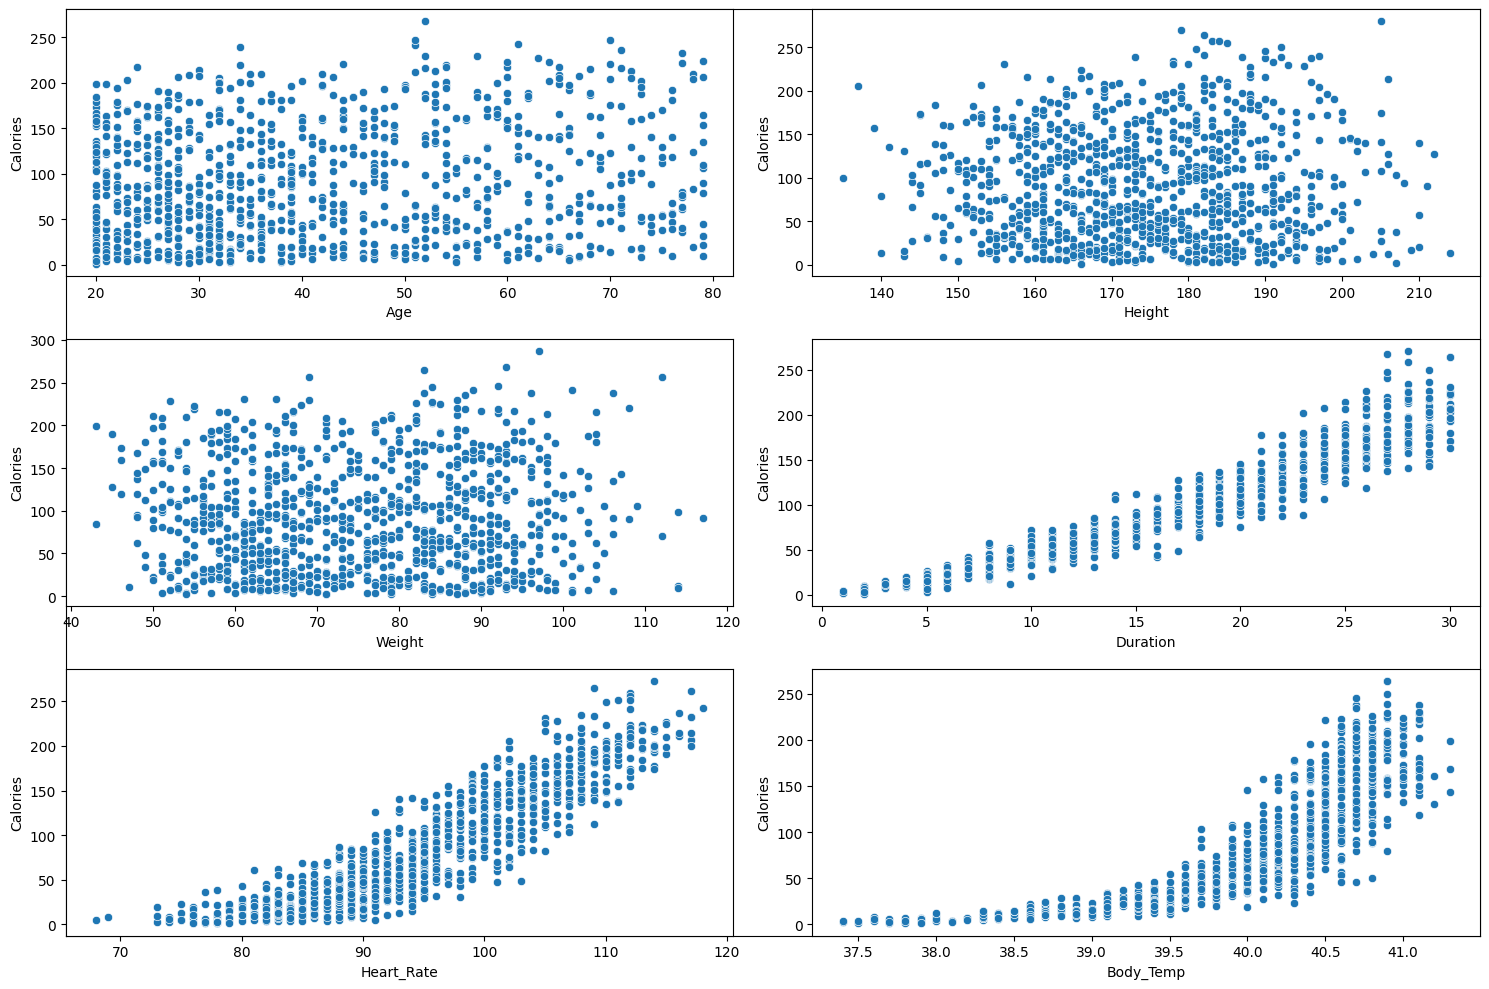

In [ ]:
features = ['Age', 'Height', 'Weight', 'Duration','Heart_Rate','Body_Temp']
plt.subplots(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    x = df.sample(1000)
    # check if the column exists in the dataframe
    if col in x.columns:
        sns.scatterplot(x=x[col],y= x['Calories'])
plt.tight_layout()
plt.show()

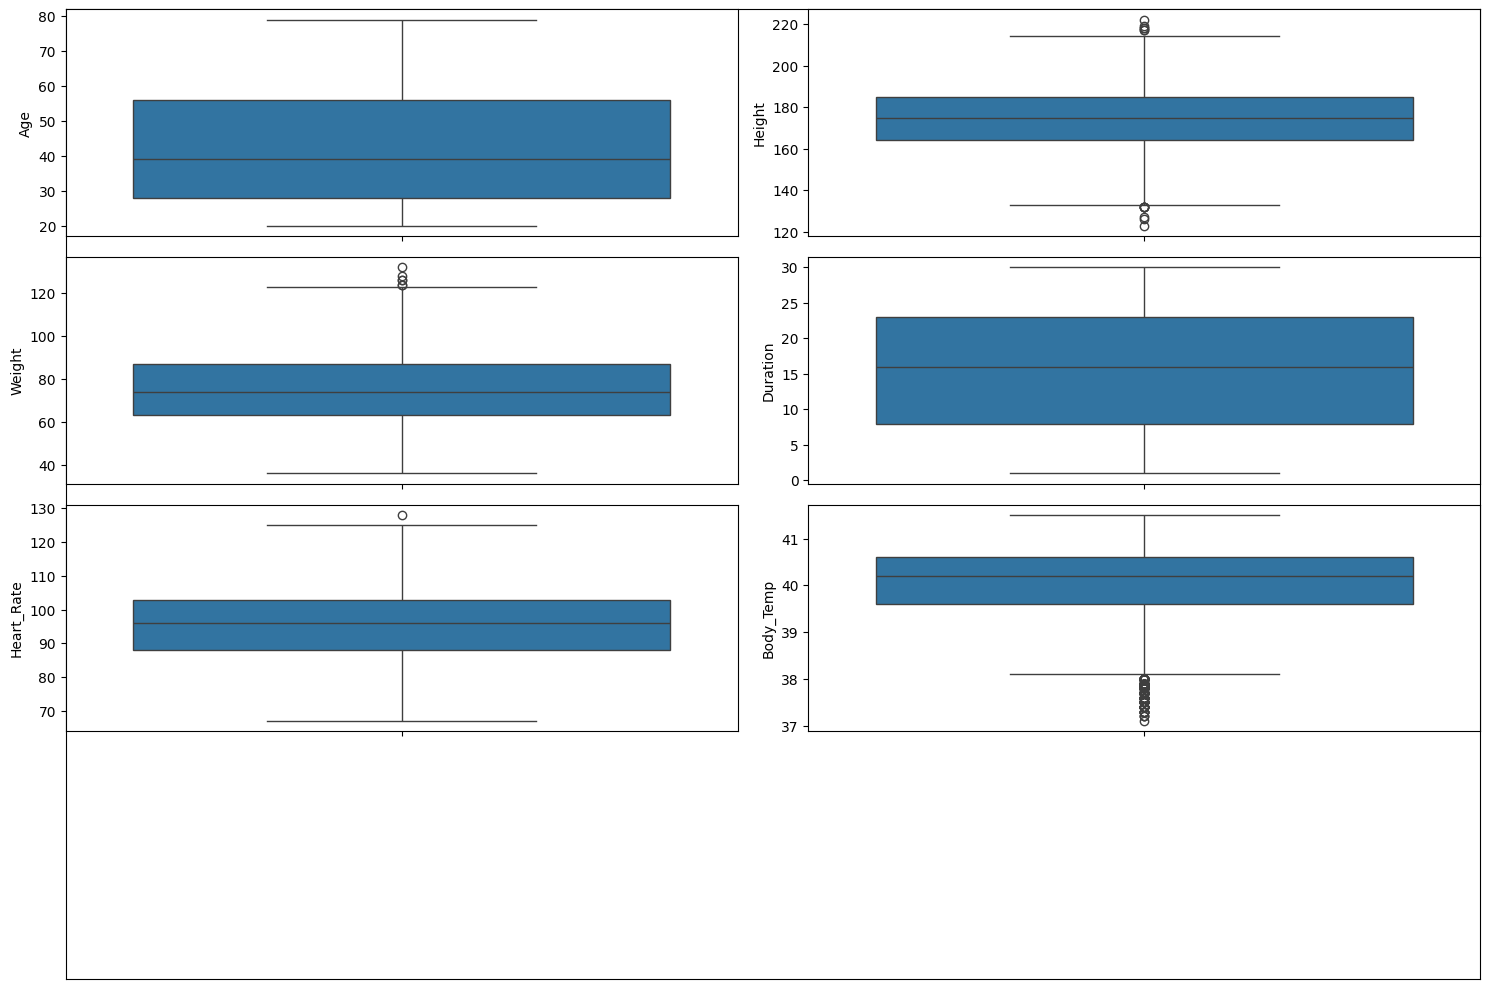

In [ ]:
plt.subplots(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
for i, col in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(df[col])
plt.tight_layout()
plt.show()

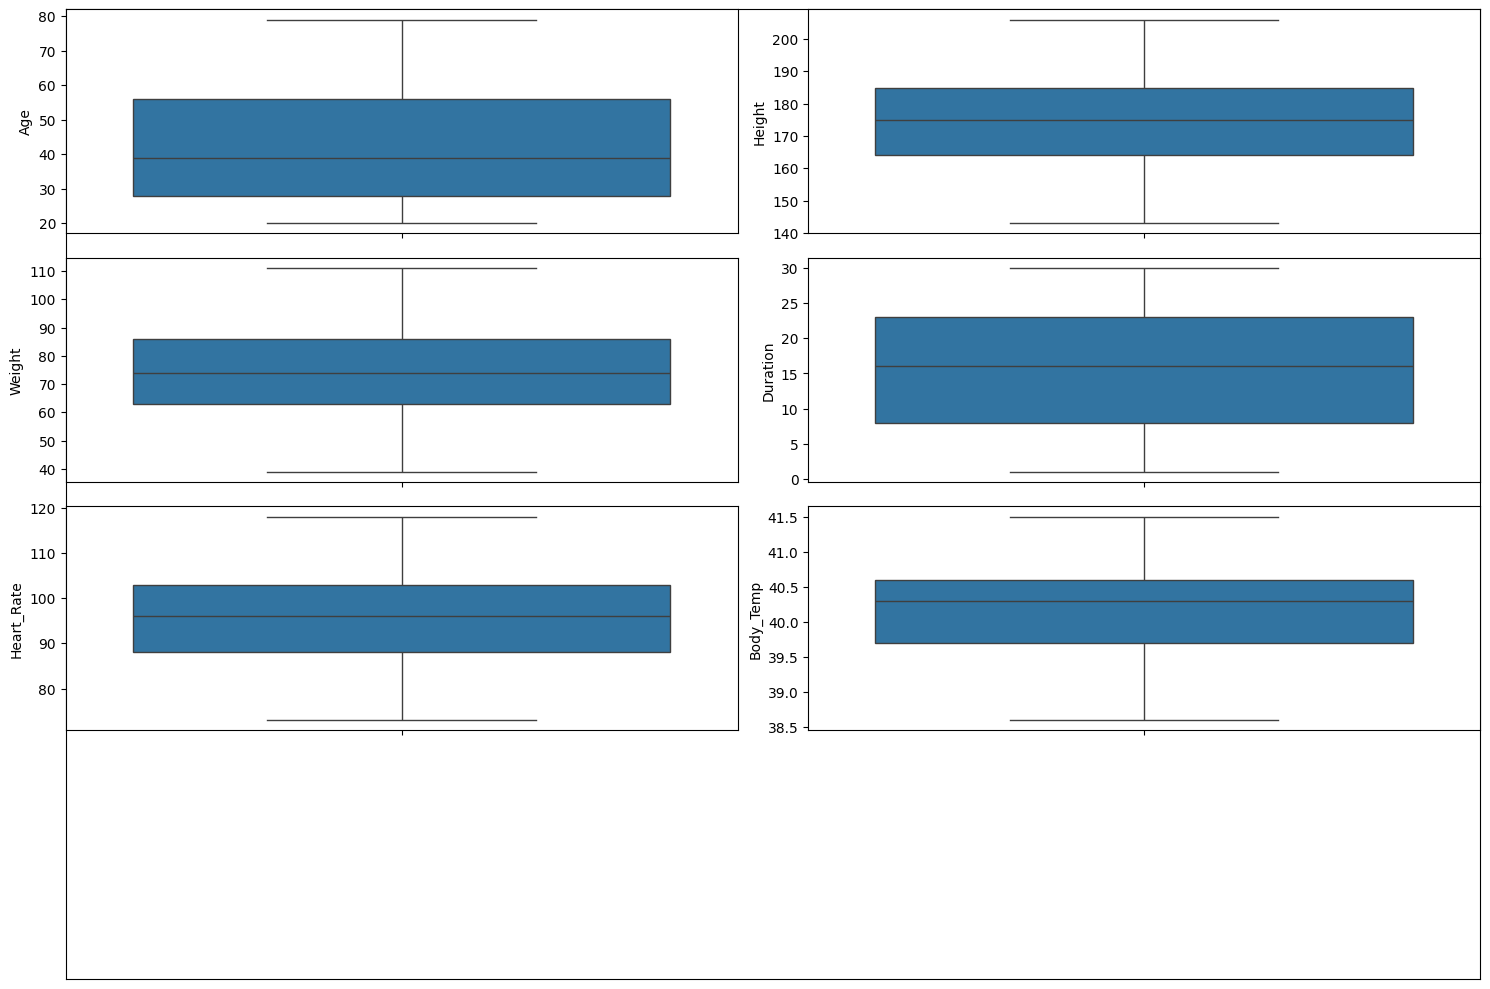

In [ ]:
# box plot after removing outliers.

def remove_outliers(df, col):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.0 * IQR
        upper_bound = Q3 + 1.0 * IQR
        df_filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        return df_filtered
    else:
        return df
plt.subplots(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
for i, col in enumerate(features):
    plt.subplot(4, 2, i + 1)
    df_filtered = remove_outliers(df, col)
    sns.boxplot(df_filtered[col])
plt.tight_layout()
plt.show()

In [ ]:
df.replace({'male': 0, 'female': 1},inplace=True)
df.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,0,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,1,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,0,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,1,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,1,27,154.0,58.0,10.0,81.0,39.8


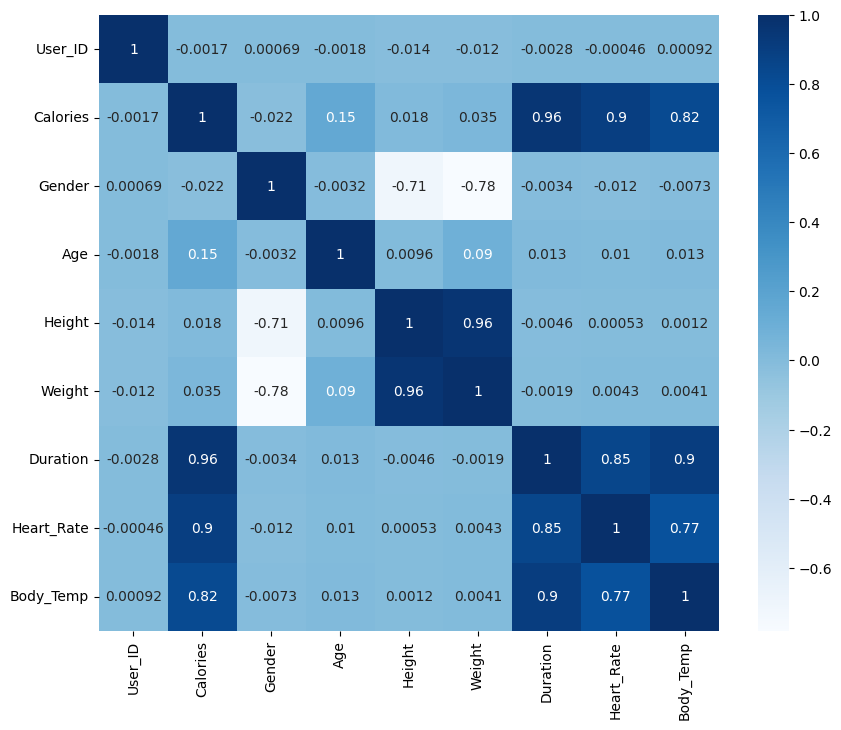

The feature with the lowest correlation to 'Calories' is: User_ID


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.show()
correlation_with_calories = correlation_matrix['Calories'].drop('Calories')
feature_to_discard = correlation_with_calories.abs().idxmin()

print(f"The feature with the lowest correlation to 'Calories' is: {feature_to_discard}")

In [ ]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values
X_train, X_test,Y_train, Y_test = train_test_split(features, target,test_size=0.2, random_state=22)
X_train.shape, X_test.shape

((12000, 7), (3000, 7))

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kf = KFold(n_splits=5, shuffle=True, random_state=22)

model = XGBRegressor(learning_rate=0.1, n_estimators=500)
mae_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    Y_train, Y_test = target[train_index], target[test_index]

    model.fit(X_train, Y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    mae_score = mae(Y_test, test_preds)
    mae_scores.append(mae_score)

average_mae = np.mean(mae_scores)
print("K-Fold MAE Scores: ", mae_scores)
print(f'Average MAE: {average_mae:.3f}')
print('Training Error : ', mae(Y_train, train_preds))
print('Testing Error : ', mae(Y_test, test_preds))
print("Accuracy: ",model.score(X_test,Y_test))

K-Fold MAE Scores:  [0.9492272310753663, 0.9621016521751881, 0.9511639250566563, 0.9809036920865377, 0.9633292068640391]
Average MAE: 0.961
Training Error :  0.5056249577303727
Testing Error :  0.9633292068640391
Accuracy:  0.9994722168258896


In [ ]:
print("*****CALORIES BURNED*****\nPlease enter the following details")
gender = int(input("Enter gender (0 for male, 1 for female): "))
age = float(input("Enter age: "))
height = float(input("Enter height (in cm): "))
weight = float(input("Enter weight (in kg): "))
duration = float(input("Enter duration (in minutes): "))
heart_rate = float(input("Enter heart rate: "))
body_temp = float(input("Enter body temperature: "))

new_data = pd.DataFrame({'Gender': [gender],'Age': [age],'Height': [height],'Weight': [weight],'Duration': [duration],'Heart_Rate': [heart_rate],
    'Body_Temp': [body_temp]})
new_data_scaled = scaler.transform(new_data)
predicted_calories = model.predict(new_data_scaled)
print("You have burned:", predicted_calories[0],"calories")

*****CALORIES BURNED*****
Please enter the following details


In [ ]:
!pip install gradio --quiet

import gradio as gr
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor



def predict_calories(gender, age, height, weight, duration, heart_rate, body_temp):
    new_data = pd.DataFrame({'Gender': [gender], 'Age': [age], 'Height': [height],
                            'Weight': [weight], 'Duration': [duration],
                            'Heart_Rate': [heart_rate], 'Body_Temp': [body_temp]})
    new_data_scaled = scaler.transform(new_data)
    predicted_calories = model.predict(new_data_scaled)[0]
    return predicted_calories

iface = gr.Interface(
    fn=predict_calories,
    inputs=[
        gr.Radio(choices=[0, 1], label="Gender (0 for male, 1 for female)"),
        gr.Number(label="Age"),
        gr.Number(label="Height (in cm)"),
        gr.Number(label="Weight (in kg)"),
        gr.Number(label="Duration (in minutes)"),
        gr.Number(label="Heart Rate"),
        gr.Number(label="Body Temperature"),
    ],
    outputs="number",
    title="Calorie Burn Prediction",
    description="Enter your details to predict calories burned during exercise."
)

iface.launch()

In [ ]:
!pip install gradio --quiet

import gradio as gr
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import XGBoostRegressor



def predict_calories(gender, age, height, weight, duration, heart_rate, body_temp):
    new_data = pd.DataFrame({'Gender': [gender], 'Age': [age], 'Height': [height],
                            'Weight': [weight], 'Duration': [duration],
                            'Heart_Rate': [heart_rate], 'Body_Temp': [body_temp]})
    new_data_scaled = scaler.transform(new_data)
    predicted_calories = model.predict(new_data_scaled)[0]
    return predicted_calories

iface = gr.Interface(
    fn=predict_calories,
    inputs=[
        gr.Radio(choices=[0, 1], label="Gender (0 for male, 1 for female)"),
        gr.Number(label="Age"),
        gr.Number(label="Height (in cm)"),
        gr.Number(label="Weight (in kg)"),
        gr.Number(label="Duration (in minutes)"),
        gr.Number(label="Heart Rate"),
        gr.Number(label="Body Temperature"),
    ],
    outputs="number",
    title="Calorie Burnt Prediction Using XGBoost Regressor",
    description="Enter your details to predict calories burned during exercise."
)

iface.launch()